In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load CSV file
file_path = r"C:\..\..\de_hourly_energy_load.csv"  # Use the avg_hourly_processed_data_with_features found in the Data file
daily_df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)

# To convert 'time' column to datetime and set as index
daily_df['time'] = pd.to_datetime(daily_df['time'])
daily_df.set_index('time', inplace=True)


In [3]:
# To add new features that captures seasonal effects
daily_df['hour'] = daily_df.index.hour  # Extract hour of the day
daily_df['dayofweek'] = daily_df.index.dayofweek  # Extracting day of the week (0=Monday, 6=Sunday)
daily_df['is_weekend'] = daily_df['dayofweek'] >= 5  # Boolean for weekends (Saturday/Sunday)

# The holiday effects
holidays = ['2019-12-25',
    '2020-01-01', '2020-12-25',
    '2021-01-01', '2021-12-25',
    '2022-01-01', '2022-12-25', # Holidays for 2022
    '2023-01-01', '2023-12-25']  # Holidays for 2023

daily_df['is_holiday'] = daily_df.index.date.astype(str)  # Convert to string format
daily_df['is_holiday'] = daily_df['is_holiday'].isin(holidays)  # Use .isin() on the pandas Series

# To convert boolean columns to 1 and 0
daily_df['is_weekend'] = daily_df['is_weekend'].astype(int)
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)

In [4]:
# We take a subset of the data for modeling
daily_df_subset = daily_df.loc['2019-01-01':'2024-10-31', ['load', 'hour', 'is_weekend', 'is_holiday']] #'2022-10-01':'2024-12-31'
num_data_points = daily_df_subset.shape[0]
print(f"Number of data points in the interval: {num_data_points}")
cut = num_data_points -6720 # the count of the last 10 months hourly load data point equals 6720
print(daily_df_subset)
# To define training and testing datasets
train_data = daily_df_subset['load'][:cut]  # Use only the first 2000 observations for training  #7678
test_data = daily_df_subset['load'][cut:]  # Use the rest for testing// Made change here // 2000 previously

Number of data points in the interval: 51144
                         load  hour  is_weekend  is_holiday
time                                                       
2019-01-01 00:00:00  43721.75     0           0           0
2019-01-01 01:00:00  42069.00     1           0           0
2019-01-01 02:00:00  40508.00     2           0           0
2019-01-01 03:00:00  39682.50     3           0           0
2019-01-01 04:00:00  39437.50     4           0           0
...                       ...   ...         ...         ...
2024-10-31 19:00:00  59605.00    19           0           0
2024-10-31 20:00:00  56859.25    20           0           0
2024-10-31 21:00:00  54040.50    21           0           0
2024-10-31 22:00:00  51405.00    22           0           0
2024-10-31 23:00:00  48110.75    23           0           0

[51144 rows x 4 columns]


In [5]:
# In  this step we define Kalman Filter parameters
n_states = 4  # Level, Trend, Short-term Seasonality, Long-term Seasonality
n_obs = 3    # Single observed variable (energy load)

# The state transition matrix (A)
A = np.array([
    [1, 1, 0, 0],  # Level evolves with trend
    [0, 1, 0, 0],  # Trend persists
    [0, 0, 1, 0],  # Short-term seasonality persists
    [0, 0, 0, 1]   # Long-term seasonality persists
])

# The observation matrix (H)
H = np.array([[1, 1, 1, 1]])  # Observation depends on all components

# The process noise covariance (Q)
Q = np.eye(n_states) * 0.1  # Adjust for the process noise #

# The observation noise covariance (R)
R = np.array([[10]])  # Adjust for the observation noise #

# The initial state vector (x_0)
state_0 = np.array([train_data[0], 0, 0, 0])  # Initialize with first value of energy load and zeros for others #

# The initial state covariance (P_0)
P_0 = np.eye(n_states) * 10  # Initial uncertainty #

# The list to contain training predictions
state_estimates = []  # stores corrected state estimates
predicted_energy_load_train = []  # stores predicted energy load

In [6]:
# To initialize state and covariance
state_prev = state_0
P_prev = P_0
# Kalman Filter training loop
for t in range(len(train_data)):
    # Prediction step
    state_pred = A @ state_prev  # Predicted state
    P_pred = A @ P_prev @ A.T + Q  # Predicted state covariance

    # Predict energy load (observation)
    energy_load_pred = H @ state_pred

    # Update step
    observation_residual = train_data[t] - energy_load_pred  # Residual (innovation)
    S = H @ P_pred @ H.T + R  # Innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman Gain

    state_updated = state_pred + K @ observation_residual  # Corrected state
    P_updated = (np.eye(n_states) - K @ H) @ P_pred  # Updated state covariance

    # Store results
    state_estimates.append(state_updated)
    predicted_energy_load_train.append(energy_load_pred[0])

    # Update for next step
    state_prev = state_updated
    P_prev = P_updated

# To convert training results to numpy arrays
state_estimates = np.array(state_estimates)
predicted_energy_load_train = np.array(predicted_energy_load_train)

# The inovation: forecasting rolling or expanding window
forecast_steps = len(test_data)
forecasted_energy_load = []
rolling_window_states = state_estimates[-5:]  # Example: last 5 states for rolling window


In [7]:

for t in range(forecast_steps):
    # Predict step
    state_pred = A @ state_prev  # Predict the next state
    P_pred = A @ P_prev @ A.T + Q  # Predict the state covariance

    # Predict energy load (observation)
    energy_load_pred = H @ state_pred
    forecasted_energy_load.append(energy_load_pred[0])

    # Optional: Expanding or Rolling window correction
    if t < len(test_data):
        # Use expanding window: update with test data as it becomes available
        observation_residual = test_data[t] - energy_load_pred  # Residual
        S = H @ P_pred @ H.T + R  # Innovation covariance
        K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman Gain

        # Update states based on test observation
        state_updated = state_pred + K @ observation_residual
        P_updated = (np.eye(n_states) - K @ H) @ P_pred
    else:  # This is just for safety
        # For rolling window: Use the rolling window states
        state_updated = state_pred
        P_updated = P_pred

    # Update for next step
    state_prev = state_updated
    P_prev = P_updated




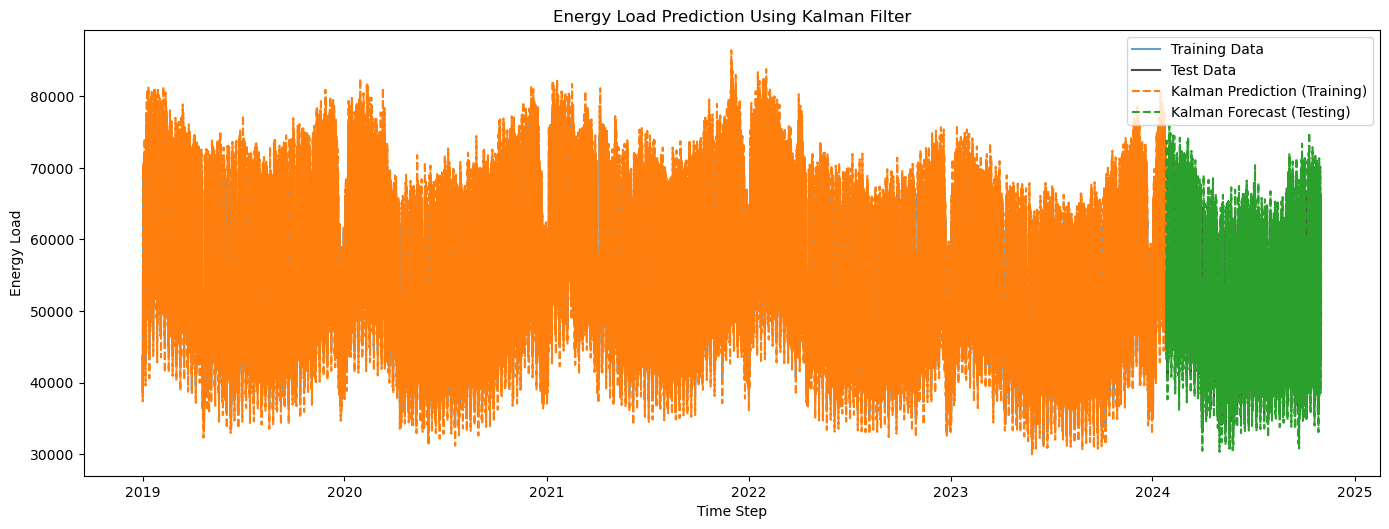

In [8]:
# Compute residuals: difference between test data and forecasted energy load
residuals = test_data - np.array(forecasted_energy_load)

# Plot results with residuals
plt.figure(figsize=(14, 10))

# Plot the training and test data
plt.subplot(2, 1, 1)  # First subplot for predictions
plt.plot(train_data.index, train_data, label="Training Data", alpha=0.7)
plt.plot(test_data.index, test_data, label="Test Data", alpha=0.7, color='black')
plt.plot(train_data.index,predicted_energy_load_train, label="Kalman Prediction (Training)", linestyle="--")
plt.plot(test_data.index, forecasted_energy_load, label="Kalman Forecast (Testing)", linestyle="--")
plt.title("Energy Load Prediction Using Kalman Filter")
plt.xlabel("Time Step")
plt.ylabel("Energy Load")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(test_data, forecasted_energy_load)
MAPE= mean_absolute_percentage_error(test_data, forecasted_energy_load)
rmse = np.sqrt(mean_squared_error(test_data, forecasted_energy_load))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE :{MAPE:.4f}")

MAE: 4245.82, RMSE: 5204.10, MAPE :0.0817
